<a href="https://colab.research.google.com/github/mcgrammar86/LOPL_YA_Diversity_Audit/blob/main/YA_audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

/bin/bash: matplotlib: command not found


In [2]:
audit_df = pd.read_csv('https://raw.githubusercontent.com/mcgrammar86/LOPL_YA_Diversity_Audit/main/YAFIC%20Diversity%20Audit.csv')
cols = audit_df.columns
for col in cols[5:]:
  audit_df[col] = (audit_df[col] == 'x')

audit_df['Author'] = audit_df['Author'].str.replace('YA-','')

audit_columns = ['Black', 'Asian', 'Latinx', 'Indigenous', 'White',
       'Pacific Islander/Native Hawaiian', 'Refugee/Immigrant', 'Gender Roles',
       'LGBTQ+', 'Family Structure', 'Adoption/Foster', 'Homeless',
       'Socio-Economic', 'Ability Diverse', 'Neurodiversity', 'Mental Illness',
       'Health Concerns', 'Culture/Religion', 'Judaism', 'Islam/Muslim',
       'Hinduism', 'Own Voices']

audit_df['diversity_score'] = audit_df[audit_columns].sum(axis=1)

In [3]:
audit_df['diversity_score'].value_counts().sort_index()

0      76
1     923
2     550
3     353
4     199
5     119
6      39
7      15
8       4
9       4
10      1
12      1
Name: diversity_score, dtype: int64

In [4]:
# There are some titles with no diversity categories marked as present. Let's export those so the library can investigate.
audit_df[audit_df['diversity_score']==0].to_csv('diversity_audit_no_data.csv')

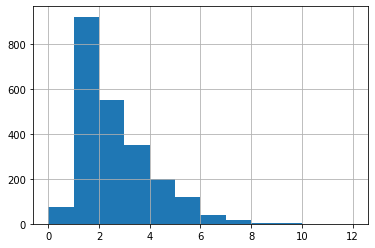

In [5]:
audit_df['diversity_score'].hist(bins=12)

In [6]:
# For now, let's remove titles with no diversity categories present, assuming that is an error
audit_df = audit_df[audit_df['diversity_score'] > 0]

In [7]:
!pip install censusdata
import censusdata

     |████████████████████████████████| 30.3MB 115kB/s 
  Created wheel for censusdata: filename=CensusData-1.13-cp37-none-any.whl size=32269382 sha256=9fb5ba08b9b2c8fd22842da6103310b28133701962ae36165461bbc9e9a51cde
  Stored in directory: /root/.cache/pip/wheels/e4/7f/e0/7fbb20cef77b96b59344deaf633a1dc571f76f229d4a06074e
Successfully built censusdata


In [8]:
lake_oswego_geocode = censusdata.censusgeo([('state', '41'), ('place', '40550')])

In [9]:
# this is all ages, but it's possible to limit to specific age brackets: 10-14, 15-17, 18-19, 20, 21
race_table_info = censusdata.censustable('acs5', 2019, 'B02001')
race_table_vars = list(race_table_info.keys())[:6]
race_table = censusdata.download('acs5', 2019, lake_oswego_geocode, race_table_vars)


In [10]:
race_table_columns = ['Total','White','Black','Indigenous','Asian','Pacific Islander/Native Hawaiian']
race_table.columns = race_table_columns
race_table.reset_index(inplace=True, drop=True)
race_table

,Total,White,Black,Indigenous,Asian,Pacific Islander/Native Hawaiian
0,39127,33567,405,286,2404,173


In [11]:
lake_oswego_population = race_table.loc[0,'Total']
proportions_table = race_table / lake_oswego_population
proportions_table = proportions_table.drop('Total', axis=1)

In [12]:
hispanic_table_info = censusdata.censustable('acs5', 2019, 'B03001')
hispanic_table_vars = list(hispanic_table_info.keys())[:3]
hispanic_table = censusdata.download('acs5', 2019, lake_oswego_geocode, hispanic_table_vars)

In [13]:
hispanic_table_column_names = ['Total','Not Hispanic or Latino', 'Hispanic or Latino']
hispanic_table.columns = hispanic_table_column_names
hispanic_table.reset_index(inplace=True, drop=True)
hispanic_proportion = hispanic_table.loc[0,'Hispanic or Latino'] / hispanic_table.loc[0,'Total']

proportions_table['Latinx'] = hispanic_proportion

In [14]:
immigration_table_info = censusdata.censustable('acs5', 2019, 'B05002')

immigrant_table = censusdata.download('acs5', 2019, lake_oswego_geocode, ['B05002_009E'])
immigrant_table.reset_index(inplace=True, drop=True)
immigrant_proportion = (immigrant_table.loc[0,'B05002_009E'] / lake_oswego_population)

proportions_table['Refugee/Immigrant'] = immigrant_proportion

In [15]:
neurodiversity_table_info = censusdata.censustable('acs5', 2019, 'B18104')
neurodiversity_table_info
neurodiversity_vars = ['B18104_004E', 'B18104_007E','B18104_010E','B18104_013E','B18104_016E', 'B18104_020E','B18104_023E','B18104_026E','B18104_029E','B18104_032E']
neurodiversity_table = censusdata.download('acs5', 2019, lake_oswego_geocode, neurodiversity_vars)
neurodiverse_population = neurodiversity_table.values.sum()
neurodiverse_proportion = neurodiverse_population / lake_oswego_population
proportions_table['Neurodiversity'] = neurodiverse_proportion

In [16]:
# Should this be limited to specific age range?

ability_table_info = censusdata.censustable('acs5', 2019, 'B18101')
ability_table_info
ability_vars = ['B18101_004E', 'B18101_007E','B18101_010E','B18101_013E','B18101_016E', 'B18101_019E','B18101_023E','B18101_026E','B18101_029E','B18101_032E', 'B18101_035E', 'B18101_038E']
ability_table = censusdata.download('acs5', 2019, lake_oswego_geocode, ability_vars)
ability_population = ability_table.values.sum()
ability_proportion = ability_population / lake_oswego_population
proportions_table['Ability Diverse'] = ability_proportion

In [17]:
adopted_children = censusdata.download('acs5', 2019, lake_oswego_geocode, ['B09019_016E']).values
proportions_table['Adoption/Foster'] = adopted_children / lake_oswego_population

In [18]:
# According to the Williams Institute, approximately 5.6% of Oregon's population identifies as LGBTQ+
proportions_table['LGBTQ+'] = 0.056

In [19]:
proportions_table.index=['LOPL Census']
proportions_table = proportions_table.T

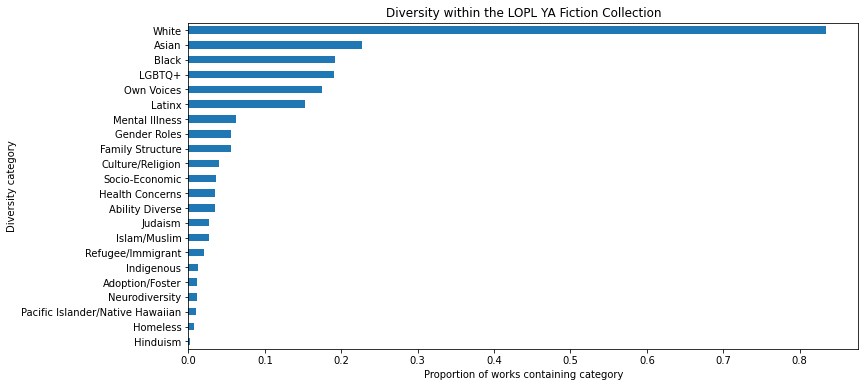

In [20]:
fig, ax = plt.subplots(figsize=(12,6))
audit_df[audit_columns].mean(axis=0).sort_values().plot.barh()
plt.title('Diversity within the LOPL YA Fiction Collection')
ax.set_xlabel('Proportion of works containing category')
ax.set_ylabel('Diversity category')
plt.show()

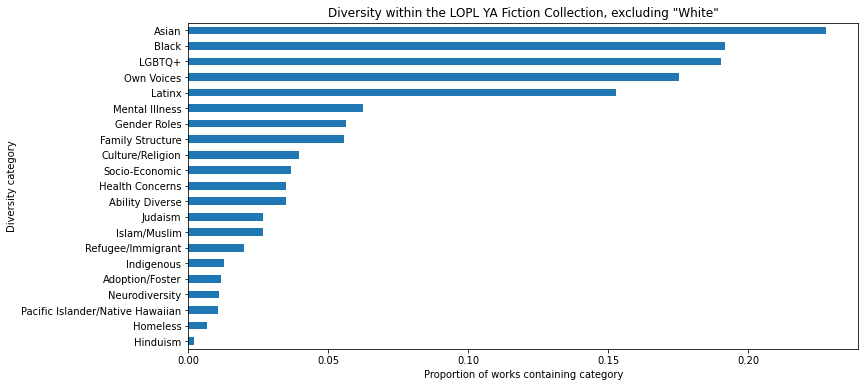

In [21]:
fig, ax = plt.subplots(figsize=(12,6))
audit_df[audit_columns].drop('White',axis=1).mean(axis=0).sort_values().plot.barh()
plt.title('Diversity within the LOPL YA Fiction Collection, excluding "White"')
ax.set_xlabel('Proportion of works containing category')
ax.set_ylabel('Diversity category')
plt.show()

In [22]:
cols = ['Black', 'Asian', 'Latinx', 'Indigenous', 'White', 'Pacific Islander/Native Hawaiian', 'Refugee/Immigrant', 'LGBTQ+', 'Neurodiversity','Ability Diverse','Adoption/Foster']
collection_proportions = pd.DataFrame(audit_df[cols].mean(axis=0).sort_values(ascending=False))
collection_proportions.columns = ['LOPL YA Collection']
ratios_df = pd.concat([collection_proportions, proportions_table], axis=1)

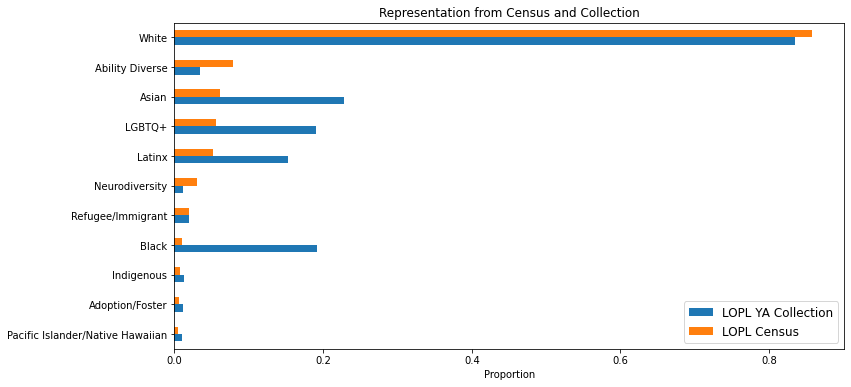

In [23]:
ratios_df.sort_values('LOPL Census').plot.barh(figsize=(12,6))
plt.legend(fontsize=12)
plt.title('Representation from Census and Collection')
plt.xlabel('Proportion')
plt.show()

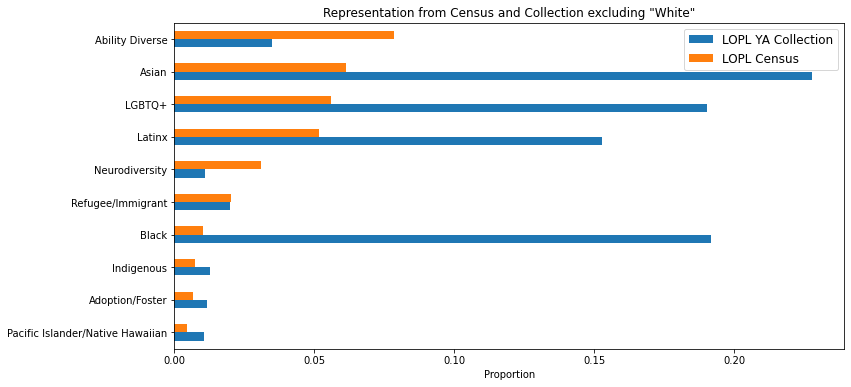

In [24]:
ratios_df.drop('White',axis=0).sort_values('LOPL Census').plot.barh(figsize=(12,6))
plt.legend(fontsize=12)
plt.title('Representation from Census and Collection excluding "White"')
plt.xlabel('Proportion')
plt.show()

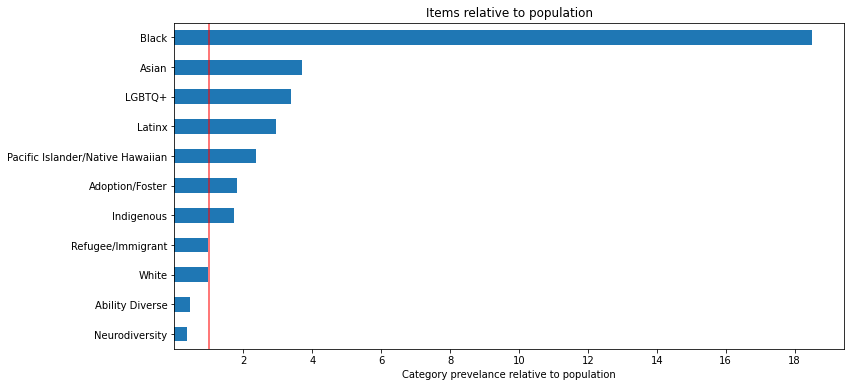

In [25]:

ratios_df['representation_ratio'] = ratios_df['LOPL YA Collection'] / ratios_df['LOPL Census']
ratios_df['representation_ratio'].sort_values().plot.barh(figsize=(12,6))
plt.axvline(1, color='red', alpha=0.7)
plt.xticks(range(2,20,2))
plt.title('Items relative to population')
plt.xlabel('Category prevelance relative to population')
plt.show()


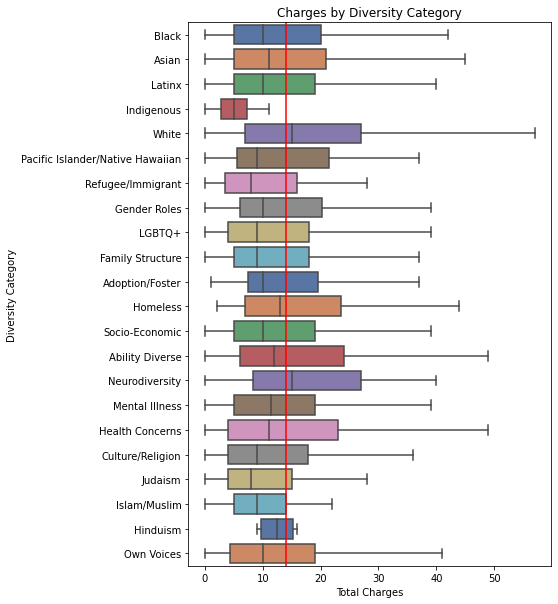

In [26]:
melted = audit_df.melt(id_vars=['Total Charges'], value_vars=audit_columns, var_name='Diversity Category')
melted = melted[melted['value']].drop('value', axis=1)
pd.concat([melted,])
median_charges = audit_df['Total Charges'].median()

fig = plt.figure(figsize=(6.5,10))
sns.boxplot(data=melted, x='Total Charges', y='Diversity Category', palette='deep', showfliers=False)
plt.axvline(median_charges, color='red')
plt.title('Charges by Diversity Category')
plt.show()


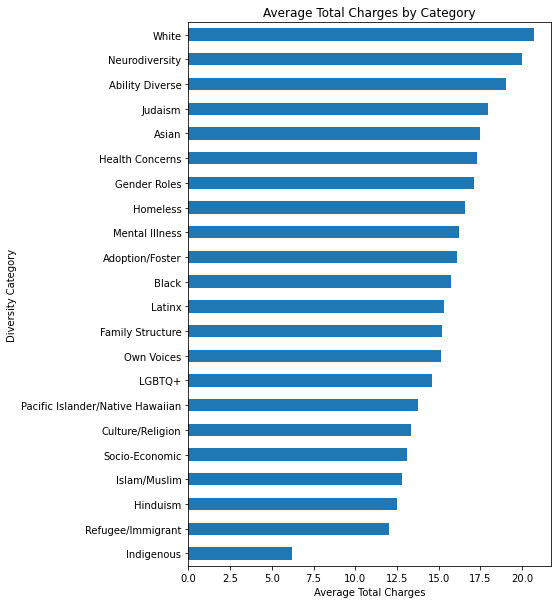

In [27]:
melted.pivot_table(index='Diversity Category', values='Total Charges').sort_values('Total Charges').plot.barh(legend=False, figsize=(6.5,10))
plt.title('Average Total Charges by Category')
plt.xlabel('Average Total Charges')
plt.show()

This is an explanation

In [28]:
ov_dict = {'LOPL YA Fiction':audit_df['Own Voices'].mean()}
for col in audit_columns[:-1]:
   total = audit_df[col].sum()
   ov = (audit_df[col] & audit_df['Own Voices']).sum()
   ov_dict[col] = ov/total
   #print('{} is {:.1%} own voices'.format(col, ov/total))



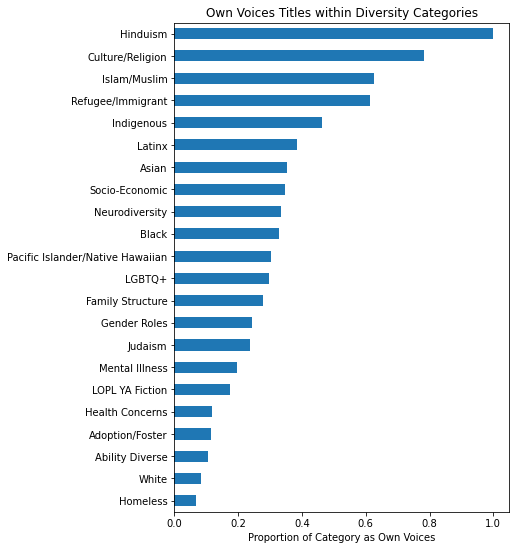

In [29]:
ov_proportions  = pd.Series(ov_dict,index=ov_dict.keys())
ov_proportions.sort_values().plot.barh(figsize=(6,9))
plt.title('Own Voices Titles within Diversity Categories')
plt.xlabel('Proportion of Category as Own Voices')
plt.show()

In [30]:
# how does this collection compare to reports from the publishing industry?
# CCBC studies

In [31]:
audit_df.columns

Index(['Author', 'Item Barcode', 'Catalog Title', 'Total Charges',
       'Item Created Date', 'Black', 'Asian', 'Latinx', 'Indigenous', 'White',
       'Pacific Islander/Native Hawaiian', 'Refugee/Immigrant', 'Gender Roles',
       'LGBTQ+', 'Family Structure', 'Adoption/Foster', 'Homeless',
       'Socio-Economic', 'Ability Diverse', 'Neurodiversity', 'Mental Illness',
       'Health Concerns', 'Culture/Religion', 'Judaism', 'Islam/Muslim',
       'Hinduism', 'Own Voices', 'diversity_score'],
      dtype='object')

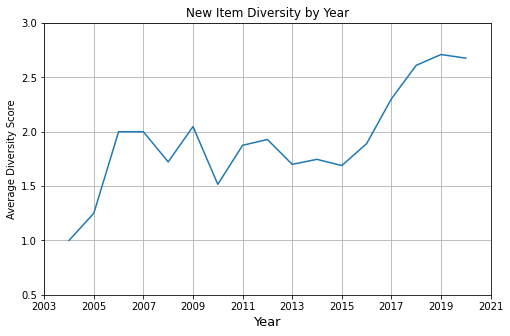

In [32]:
audit_df['Item Created Date'] = pd.to_datetime(audit_df['Item Created Date'])
audit_df['Item Added Year'] = audit_df['Item Created Date'].apply(lambda x: x.year)
diversity_by_year = audit_df.groupby('Item Added Year')['diversity_score'].agg(['mean'])

fig, ax = plt.subplots(figsize=(8,5))
diversity_by_year = diversity_by_year[diversity_by_year.index > 2003]

plt.plot(diversity_by_year.index, diversity_by_year)
plt.title('New Item Diversity by Year')
plt.xlabel('Year', fontsize=13)
plt.ylabel('Average Diversity Score')
plt.yticks([.5,1,1.5,2,2.5,3])
plt.xticks(range(2003,2022,2))
plt.grid()
plt.show()
